In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
from scipy.interpolate import interp1d

from sklearn.impute import KNNImputer
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings
warnings.filterwarnings('ignore')

import glob
from tqdm.notebook import tqdm


import scienceplots
plt.style.use(['ieee','bright','no-latex'])
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["figure.titleweight"]=25

np.random.seed(18)

In [2]:
def linear_int(data):
    valid_indices = np.arange(len(data))
    valid_data = ~np.isnan(data)
    interpolated_data = np.interp(valid_indices, valid_indices[valid_data], data[valid_data])
    return list(interpolated_data)

def knn_interpolate(data):
    arr=data.copy()
    time=np.arange(1,len(arr)+1,1)
    df=pd.DataFrame({'time':time,'arr':arr})
    knn=KNNImputer(n_neighbors=10)
    imputed=pd.DataFrame(knn.fit_transform(np.array(df)),columns=df.columns)['arr'].values
    return imputed


def spline_interpolation(arr, degree):
    x=arr.copy()
    nan_indices = np.isnan(x)
    non_nan_indices = np.arange(len(x))[~nan_indices]
    non_nan_values = arr[~nan_indices]

    if degree==1:
        interpolator = interp1d(non_nan_indices, non_nan_values, kind='slinear', fill_value='extrapolate')
    elif degree==2:
        interpolator = interp1d(non_nan_indices, non_nan_values, kind='quadratic', fill_value='extrapolate')
    elif degree==3:
        interpolator = interp1d(non_nan_indices, non_nan_values, kind='cubic', fill_value='extrapolate')
    
    interpolated_values = interpolator(np.arange(len(x)))

    return interpolated_values

In [3]:
from tslearn.metrics import dtw
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

def hierarchical_clustering_dtw(time_series_data, num_clusters):
    # Compute the distance matrix using DTW
    n = len(time_series_data)
    distance_matrix = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            distance_matrix[i][j] = dtw(time_series_data[i], time_series_data[j])
    
    # Perform hierarchical clustering using average linkage
    linkage_matrix = linkage(distance_matrix, method='ward') # average worked
    
    # Plot dendrogram
    plt.figure(figsize=(10, 5))
    dendrogram(linkage_matrix)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Time Series Index')
    plt.ylabel('Distance')
    plt.show()
    
    # Extract cluster labels from dendrogram
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    return cluster_labels

In [4]:
def process_files(dataframe):
    dataframe['from date']=pd.to_datetime(dataframe['from date'])
    dataframe=dataframe[(dataframe['from date']>='01-01-2023')&(dataframe['from date']<='31-12-2023')]
    dataframe = dataframe[['from date','PM2.5','PM10','SO2',"NO2",'Ozone','NH3']]
    cols = ['PM2.5','PM10','SO2',"NO2",'Ozone','NH3']
    arr=[]

    dataframe = dataframe.resample('H', on='from date').mean().reset_index()

    for col in cols:
        try:
            dataframe[col]=linear_int(dataframe[col])
        except:
            return False,arr  ## Modified process_file here
    
    for col in cols:
        arr.append(np.array(dataframe[col].values))

    return True,np.array(arr).T

In [5]:
path_data="D:\\BTP\\Data\\site_data_processed"
csv_files=glob.glob(path_data+'/*.csv')
cols=['PM2.5','PM10','SO2','NO2','Ozone','NH3']

df_site=pd.read_csv('site_info.csv')

df_comp_dup=pd.read_excel('Score_all_files.xlsx')
df_mad_anoms=pd.read_excel('MAD_anomalies.xlsx')

cols_names=list(df_mad_anoms.columns)
cols_names[0]='SiteId'
df_mad_anoms.columns=cols_names

req_ids=df_site[df_site['City']=='Delhi'].reset_index(drop=True).siteId.values
filtered_df=df_comp_dup[df_comp_dup['SiteId'].isin(req_ids)]
filtered_df=filtered_df.merge(df_mad_anoms,on='SiteId')
filtered_df.head(3)

,SiteId,SiteName,PM2.5_score,PM10_score,SO2_score,NO2_score,Ozone_score,NH3_score,PM2.5_dup_score,PM10_dup_score,...,NO2_dup_score,Ozone_dup_score,NH3_dup_score,station_name,PM2.5_anom_perc,PM10_anom_perc,SO2_anom_perc,NO2_anom_perc,Ozone_anom_perc,NH3_anom_perc
0,site_103,"CRRI Mathura Road, Delhi - IMD",0.9504,0.8954,0.0,0.9440,0.9550,0.0,0.046234,0.008562,...,3.165009,0.012557,0.0,"CRRI Mathura Road, Delhi - IMD",0.011164,0.015799,0.0,0.003470,0.015959,0.0
1,site_104,"Burari Crossing, Delhi - IMD",0.3030,0.3206,0.0,0.2155,0.2805,0.0,0.007991,0.065640,...,0.098746,0.277402,0.0,"Burari Crossing, Delhi - IMD",0.010023,0.013402,0.0,0.002192,0.013721,0.0
2,site_105,"North Campus, DU, Delhi - IMD",0.8810,0.8786,0.0,0.8863,0.8965,0.0,0.009133,0.049088,...,0.182652,0.861887,0.0,"North Campus, DU, Delhi - IMD",0.011164,0.016689,0.0,0.005228,0.019886,0.0


In [6]:
filtered_df['Anomalies_Score']=(1-filtered_df.iloc[:, -6:].prod(axis=1))
filtered_df['Completeness_Score']=(filtered_df.iloc[:, 2:8].prod(axis=1))
filtered_df['Overall_Score']=filtered_df[['Anomalies_Score','Completeness_Score']].prod(axis=1)
filtered_df[['SiteId','SiteName','Anomalies_Score','Completeness_Score','Overall_Score']].sort_values(by='Overall_Score')

,SiteId,SiteName,Anomalies_Score,Completeness_Score,Overall_Score
0,site_103,"CRRI Mathura Road, Delhi - IMD",1.0,0.000000,0.000000
10,site_116,"East Arjun Nagar, Delhi - CPCB",1.0,0.000000,0.000000
6,site_109,"Lodhi Road, Delhi - IMD",1.0,0.000000,0.000000
5,site_108,"Aya Nagar, Delhi - IMD",1.0,0.000000,0.000000
39,site_5852,"New Moti Bagh, Delhi - MHUA",1.0,0.000000,0.000000
3,site_106,"IGI Airport (T3), Delhi - IMD",1.0,0.000000,0.000000
2,site_105,"North Campus, DU, Delhi - IMD",1.0,0.000000,0.000000
1,site_104,"Burari Crossing, Delhi - IMD",1.0,0.000000,0.000000
4,site_107,"Pusa, Delhi - IMD",1.0,0.000000,0.000000
38,site_5395,"Lodhi Road, Delhi - IITM",1.0,0.000005,0.000005


## Create Data

In [7]:
timeseries_data=[]
site_ids_delhi=[]
for file_name in tqdm(csv_files):
    df=pd.read_csv(file_name)
    if (df_site[df_site['siteId'].isin([df['siteId'].unique()[0]])]['State']=='Delhi').values[0]:
        temp,arr=process_files(df)
        if temp:
            timeseries_data.append(arr)
            site_ids_delhi.append(str(df['siteId'].unique()[0]))

timeseries_data=np.array(timeseries_data)
timeseries_data.shape

  0%|          | 0/513 [00:00<?, ?it/s]

(30, 6108, 6)

## Clustering 

### Hierarchical Clustering

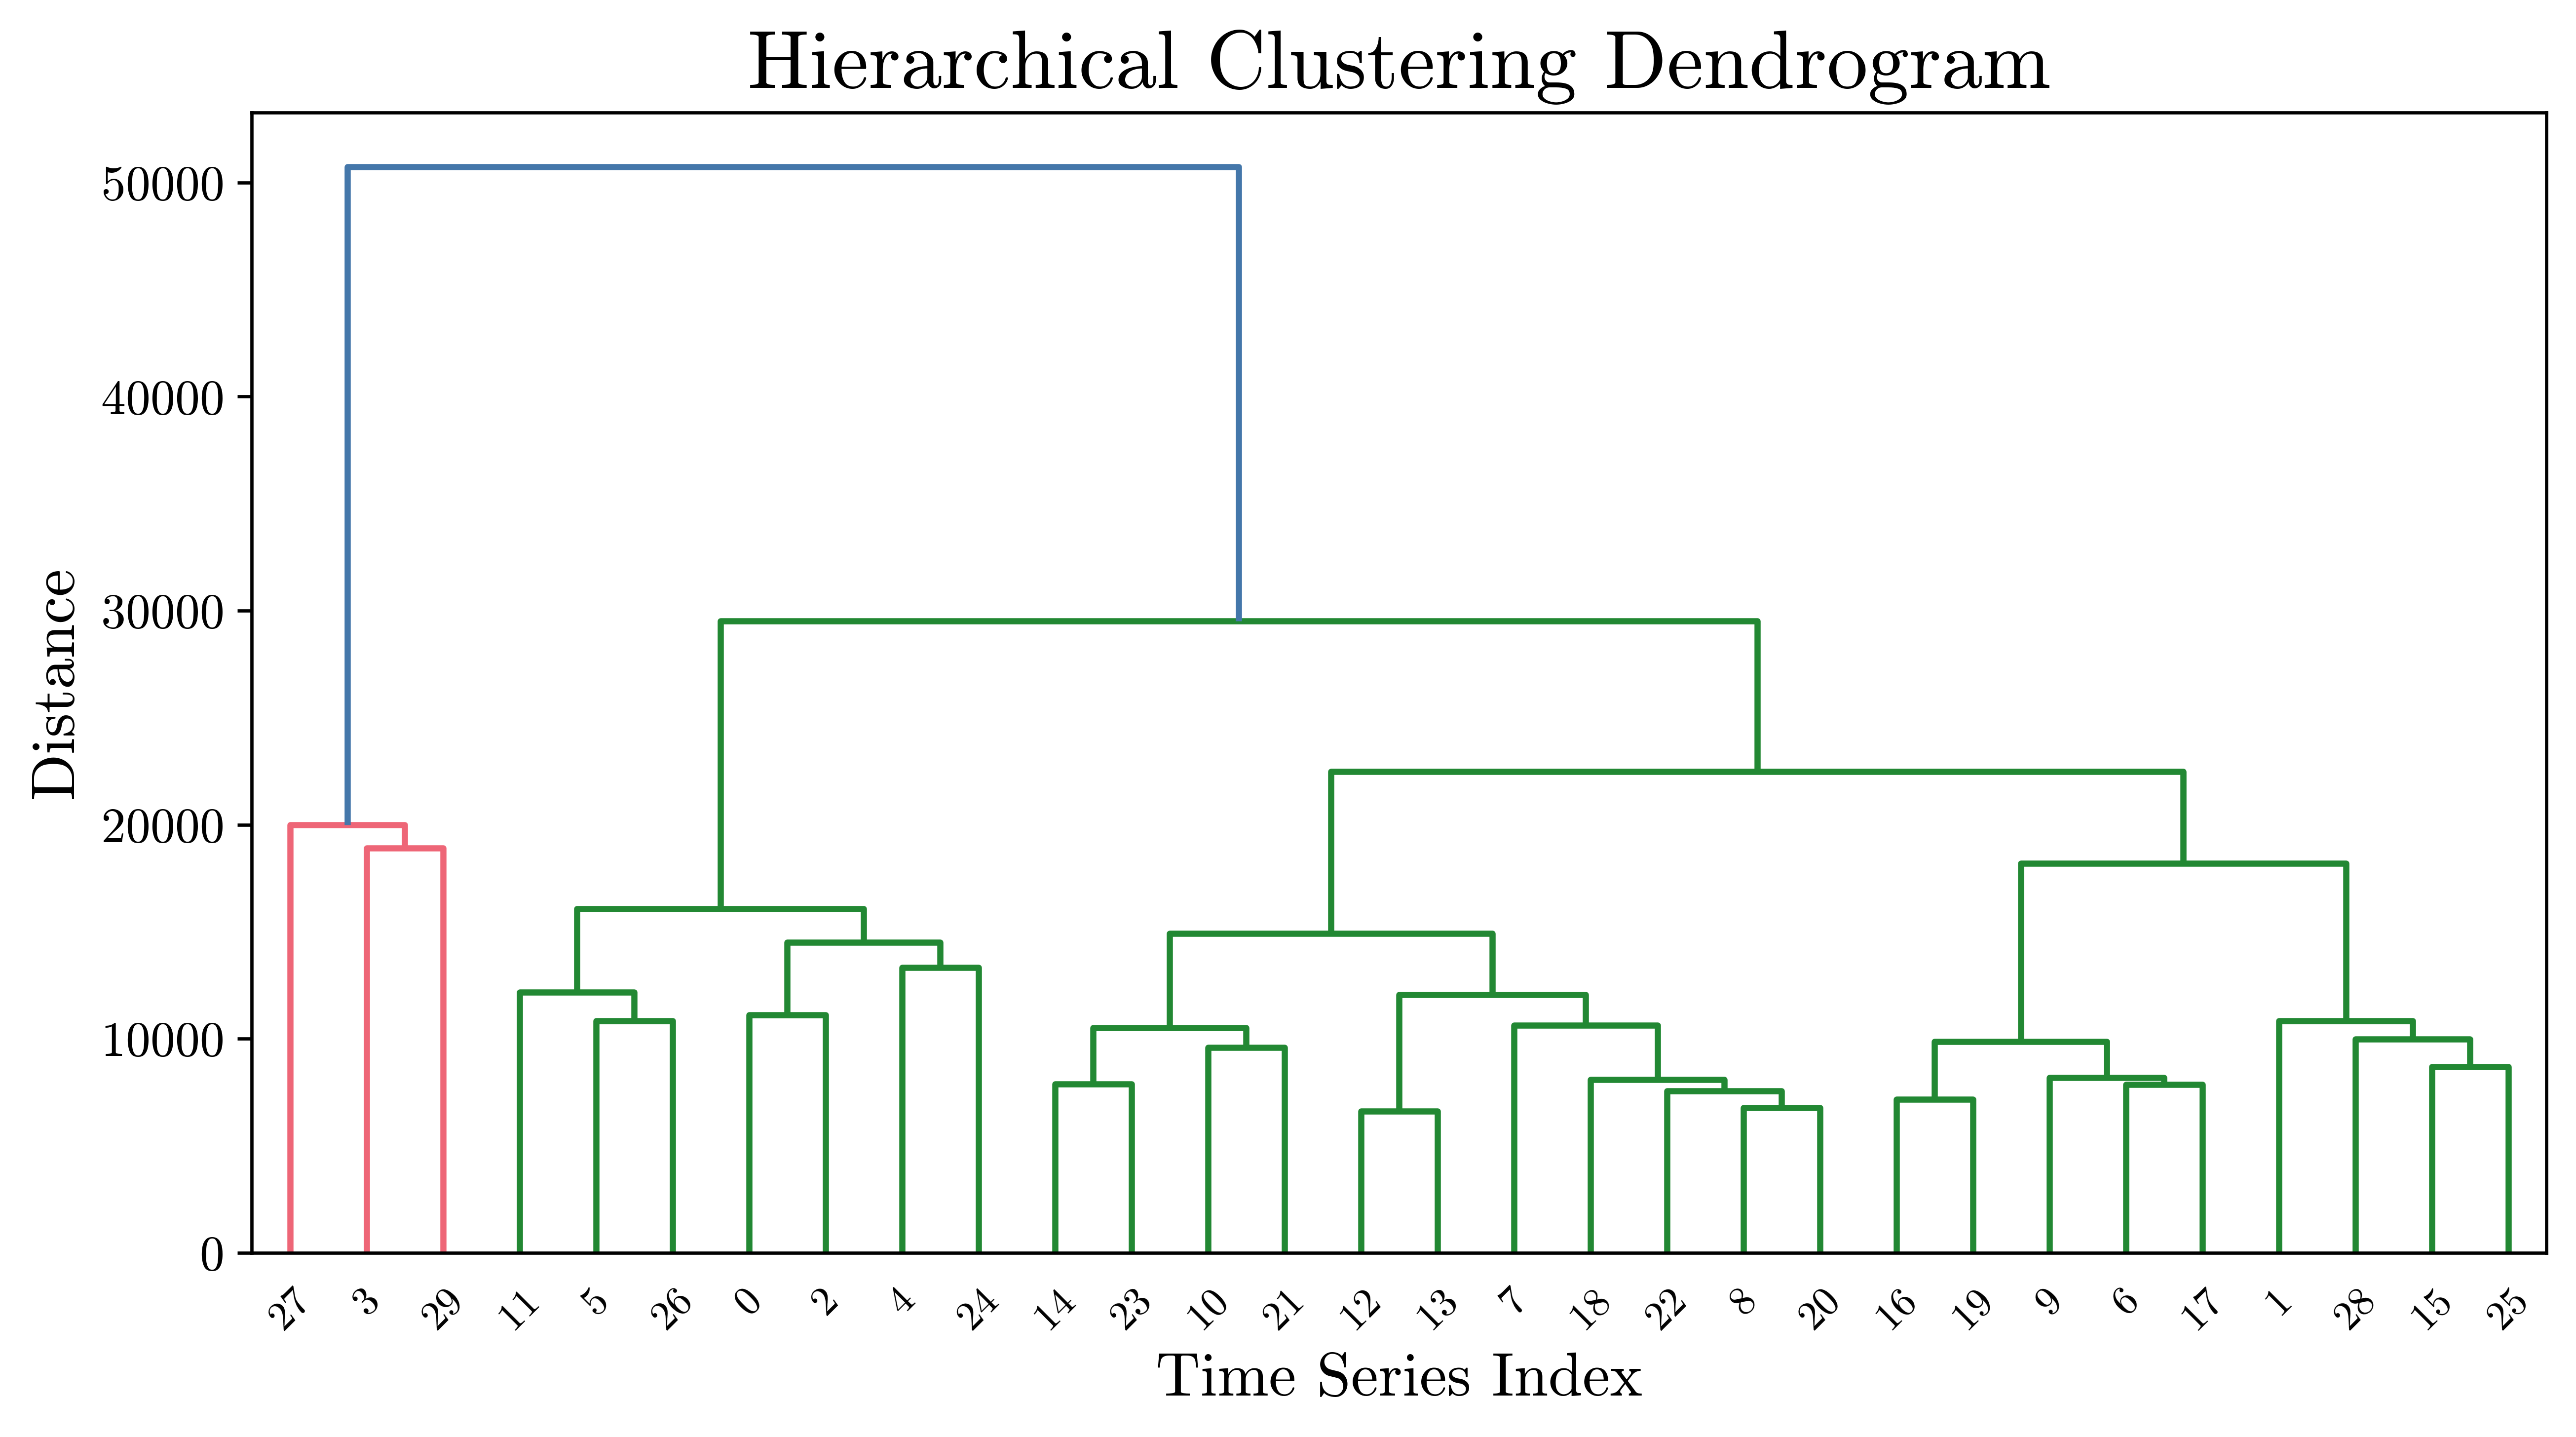

In [8]:
num_clusters = 5
cluster_labels_hc = hierarchical_clustering_dtw(timeseries_data, num_clusters)

### K Means

In [17]:
from tslearn.clustering import TimeSeriesKMeans

km= TimeSeriesKMeans(n_clusters=4, max_iter=20, n_init=2, metric='dtw',verbose=3)
km.fit(timeseries_data)
cluster_labels_kmc=km.labels_+1

Init 1


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   14.2s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   14.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   13.8s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   14.4s


39341647.799 --> 

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   12.2s


22740305.959 --> 

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   22.4s


22740305.959 --> 
Init 2


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   19.5s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   20.4s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   18.4s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   15.6s


34853669.166 --> 

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   15.1s


22958837.205 --> 

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   14.5s


22958837.205 --> 


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   14.6s


## Results

In [18]:
df_landuse=pd.read_csv('Delhi_landuse.csv')
df_delhi_clustered=pd.DataFrame({"SiteId":site_ids_delhi})
df_delhi_clustered['Kmc']=cluster_labels_kmc
#df_delhi_clustered['hc']=cluster_labels_hc
df_delhi_clustered=df_landuse.merge(df_delhi_clustered,on='SiteId')
df_delhi_clustered.head()

,SiteId,SiteName,Landuse_label,Kmc
0,site_5393,"Chandni Chowk, Delhi - IITM",2,4
1,site_114,"IHBAS, Dilshad Garden, Delhi - CPCB",3,2
2,site_118,"DTU, Delhi - CPCB",3,3
3,site_1423,"Jahangirpuri, Delhi - DPCC",3,1
4,site_5024,"Alipur, Delhi - DPCC",3,2


In [30]:
from sklearn.metrics.cluster import rand_score
#rand_score(df_delhi_clustered['Landuse_label'].values,df_delhi_clustered['hc'].values)

0.6367816091954023

In [19]:
from sklearn.metrics.cluster import rand_score
rand_score(df_delhi_clustered['Landuse_label'].values,df_delhi_clustered['Kmc'].values)

0.5609195402298851

In [20]:
df_delhi_clustered.Kmc.value_counts()

Kmc
2    16
3    12
4     1
1     1
Name: count, dtype: int64

In [22]:
df_delhi_clustered[df_delhi_clustered['Kmc']==1]

,SiteId,SiteName,Landuse_label,Kmc
3,site_1423,"Jahangirpuri, Delhi - DPCC",3,1


## Cluster Wise Analysis

In [ ]:
#df_delhi_clustered=pd.read_csv('delhi_clustered.csv')
df_delhi_clustered.hc.value_counts().sort_index()

hc
1     2
2     1
3     8
4    11
5     8
Name: count, dtype: int64

In [38]:
df_stats=pd.DataFrame({'siteId':[]})
for col in cols:
    df_stats[f'Mean_{col}']=[]

row=[]
for sid in tqdm(df_delhi_clustered.siteId.values):
    row=[]
    fname='D:\\BTP\\Data\\site_data_processed\\'+sid+'.csv'
    row.append(sid)
    df=pd.read_csv(fname)
    df=df[(df['from date']>='01-01-2022')&(df['from date']<='31-12-2023')]
    df['from date']=pd.to_datetime(df['from date'])
    df=df[['from date','PM2.5', 'PM10', 'SO2', 'NO2', 'Ozone', 'NH3']]
    df = df.resample('D', on='from date').mean().reset_index()
    for col in cols:
        df[col]=linear_int(df[col])
    row=row+list(df[cols].mean().values)
    df_stats.loc[len(df_stats)]=row
df_stats=df_stats.merge(df_delhi_clustered[['siteId','hc','Kmc']],on='siteId')
df_stats

  0%|          | 0/30 [00:00<?, ?it/s]

,siteId,Mean_PM2.5,Mean_PM10,Mean_SO2,Mean_NO2,Mean_Ozone,Mean_NH3,hc,Kmc
0,site_5024,107.187635,206.915183,14.937555,35.713529,31.427303,23.692733,5,1
1,site_301,124.017562,273.130619,16.928497,80.329578,31.756065,44.547483,2,1
2,site_1420,107.708062,213.926788,16.658760,38.755076,30.926873,35.980266,4,1
3,site_1560,120.239517,242.147285,8.911043,25.481757,32.601621,40.148245,4,1
4,site_5393,117.661938,336.867947,7.166279,41.724456,22.225099,88.971259,1,4
5,site_1421,89.363156,181.491549,13.687672,52.828430,45.407417,28.018499,5,2
6,site_118,108.544851,218.043558,12.550612,38.287190,43.410222,42.203688,3,1
7,site_1422,103.495167,252.160018,10.281023,35.371714,28.908964,44.191625,4,1
8,site_114,90.742326,155.646560,13.409370,46.403412,30.135074,47.109757,5,3
9,site_117,111.097934,171.298823,13.126146,42.885568,23.634430,41.217810,1,5


In [ ]:
df_stats.Kmc.value_counts().sort_index()

Kmc
1    19
2     5
3     4
4     1
5     1
Name: count, dtype: int64

In [ ]:
df_stats.groupby('Kmc')[['Mean_PM2.5','Mean_PM10','Mean_SO2','Mean_NO2','Mean_Ozone','Mean_NH3']].quantile(0.1).reset_index()

,Kmc,Mean_PM2.5,Mean_PM10,Mean_SO2,Mean_NO2,Mean_Ozone,Mean_NH3
0,1,95.176496,197.877626,9.706568,28.808530,24.139918,34.286633
1,2,93.492183,185.795113,8.905137,38.243819,28.575163,29.179198
2,3,83.591361,151.201298,7.344434,22.416481,30.814627,29.217493
3,4,117.661938,336.867947,7.166279,41.724456,22.225099,88.971259
4,5,111.097934,171.298823,13.126146,42.885568,23.634430,41.217810


In [ ]:
df_stats.groupby('Kmc')[['Mean_PM2.5','Mean_PM10','Mean_SO2','Mean_NO2','Mean_Ozone','Mean_NH3']].mean().reset_index()

,Kmc,Mean_PM2.5,Mean_PM10,Mean_SO2,Mean_NO2,Mean_Ozone,Mean_NH3
0,1,109.565054,225.607553,12.786995,41.093903,31.174910,43.048489
1,2,102.873851,198.550696,12.026762,47.073441,37.259086,37.587291
2,3,88.482897,163.159351,10.804492,37.980183,34.642859,36.128714
3,4,117.661938,336.867947,7.166279,41.724456,22.225099,88.971259
4,5,111.097934,171.298823,13.126146,42.885568,23.634430,41.217810


In [ ]:
df_stats.groupby('Kmc')[['Mean_PM2.5','Mean_PM10','Mean_SO2','Mean_NO2','Mean_Ozone','Mean_NH3']].quantile(0.9).reset_index()

,Kmc,Mean_PM2.5,Mean_PM10,Mean_SO2,Mean_NO2,Mean_Ozone,Mean_NH3
0,1,122.004331,254.949852,16.979572,54.233965,41.720610,56.962999
1,2,112.095716,211.330154,14.165733,54.286603,44.005928,45.435309
2,3,93.787754,180.513255,14.464860,53.853346,39.537657,43.911596
3,4,117.661938,336.867947,7.166279,41.724456,22.225099,88.971259
4,5,111.097934,171.298823,13.126146,42.885568,23.634430,41.217810


In [41]:
filtered_df[['SiteId','SiteName','Anomalies_Score','Completeness_Score','Overall_Score']].sort_values(by='Overall_Score')

,SiteId,SiteName,Anomalies_Score,Completeness_Score,Overall_Score
0,site_103,"CRRI Mathura Road, Delhi - IMD",1.0,0.000000,0.000000
10,site_116,"East Arjun Nagar, Delhi - CPCB",1.0,0.000000,0.000000
6,site_109,"Lodhi Road, Delhi - IMD",1.0,0.000000,0.000000
5,site_108,"Aya Nagar, Delhi - IMD",1.0,0.000000,0.000000
39,site_5852,"New Moti Bagh, Delhi - MHUA",1.0,0.000000,0.000000
3,site_106,"IGI Airport (T3), Delhi - IMD",1.0,0.000000,0.000000
2,site_105,"North Campus, DU, Delhi - IMD",1.0,0.000000,0.000000
1,site_104,"Burari Crossing, Delhi - IMD",1.0,0.000000,0.000000
4,site_107,"Pusa, Delhi - IMD",1.0,0.000000,0.000000
38,site_5395,"Lodhi Road, Delhi - IITM",1.0,0.000005,0.000005


In [14]:
df_site

,siteId,siteName,address,City,State,latitude,longitude
0,site_5094,"SIDCO Kurichi, Coimbatore - TNPCB","Coimbatore,Tamil Nadu",Coimbatore,Tamil Nadu,10.942451,76.978996
1,site_5261,"Muradpur, Patna - BSPCB","Patna,Bihar",Patna,Bihar,25.619651,85.147382
2,site_5044,"Municipal Corporation Office, Dharuhera - HSPCB","Dharuhera,Haryana",Dharuhera,Haryana,28.206800,76.799700
3,site_5072,"Rishi Nagar, Kaithal - HSPCB","Kaithal,Haryana",Kaithal,Haryana,29.800600,76.415500
4,site_163,"Peenya, Bengaluru - CPCB","Bengaluru,Karnataka",Bengaluru,Karnataka,13.027020,77.494094
...,...,...,...,...,...,...,...
508,site_5048,"Sector-18, Panipat - HSPCB","Panipat,Haryana",Panipat,Haryana,29.497973,76.993331
509,site_5051,"F-Block, Sirsa - HSPCB","Sirsa,Haryana",Sirsa,Haryana,29.536400,75.015800
510,site_5052,"Patti Mehar, Ambala - HSPCB","Ambala,Haryana",Ambala,Haryana,30.379589,76.778328
511,site_5053,"Shastri Nagar, Narnaul - HSPCB","Narnaul,Haryana",Narnaul,Haryana,28.060249,76.113115


In [15]:
#df_site.merge(df_delhi_clustered.rename({'SiteId':'siteId'},axis=1),on='siteId').to_csv('delhi_clustered_2023.csv',index=False)

In [85]:
df1=pd.read_csv(path_data+'//site_1434.csv') # Warzipur
df1['from date']=pd.to_datetime(df1['from date'])
df1=df1[(df1['from date']>='01-01-2022')&(df1['from date']<='31-12-2023')]
df1['PM2.5']=linear_int(df1['PM2.5'].values)

df2=pd.read_csv(path_data+'//site_1424.csv') #Residential Dwaraka
df2['from date']=pd.to_datetime(df1['from date'])
df2=df2[(df2['from date']>='01-01-2022')&(df2['from date']<='31-12-2023')]
df2['PM2.5']=linear_int(df2['PM2.5'].values)

df3=pd.read_csv(path_data+'//site_1428.csv') # 
df3['from date']=pd.to_datetime(df1['from date'])
df3=df3[(df3['from date']>='01-01-2022')&(df3['from date']<='31-12-2023')]
df3['PM2.5']=linear_int(df3['PM2.5'].values)

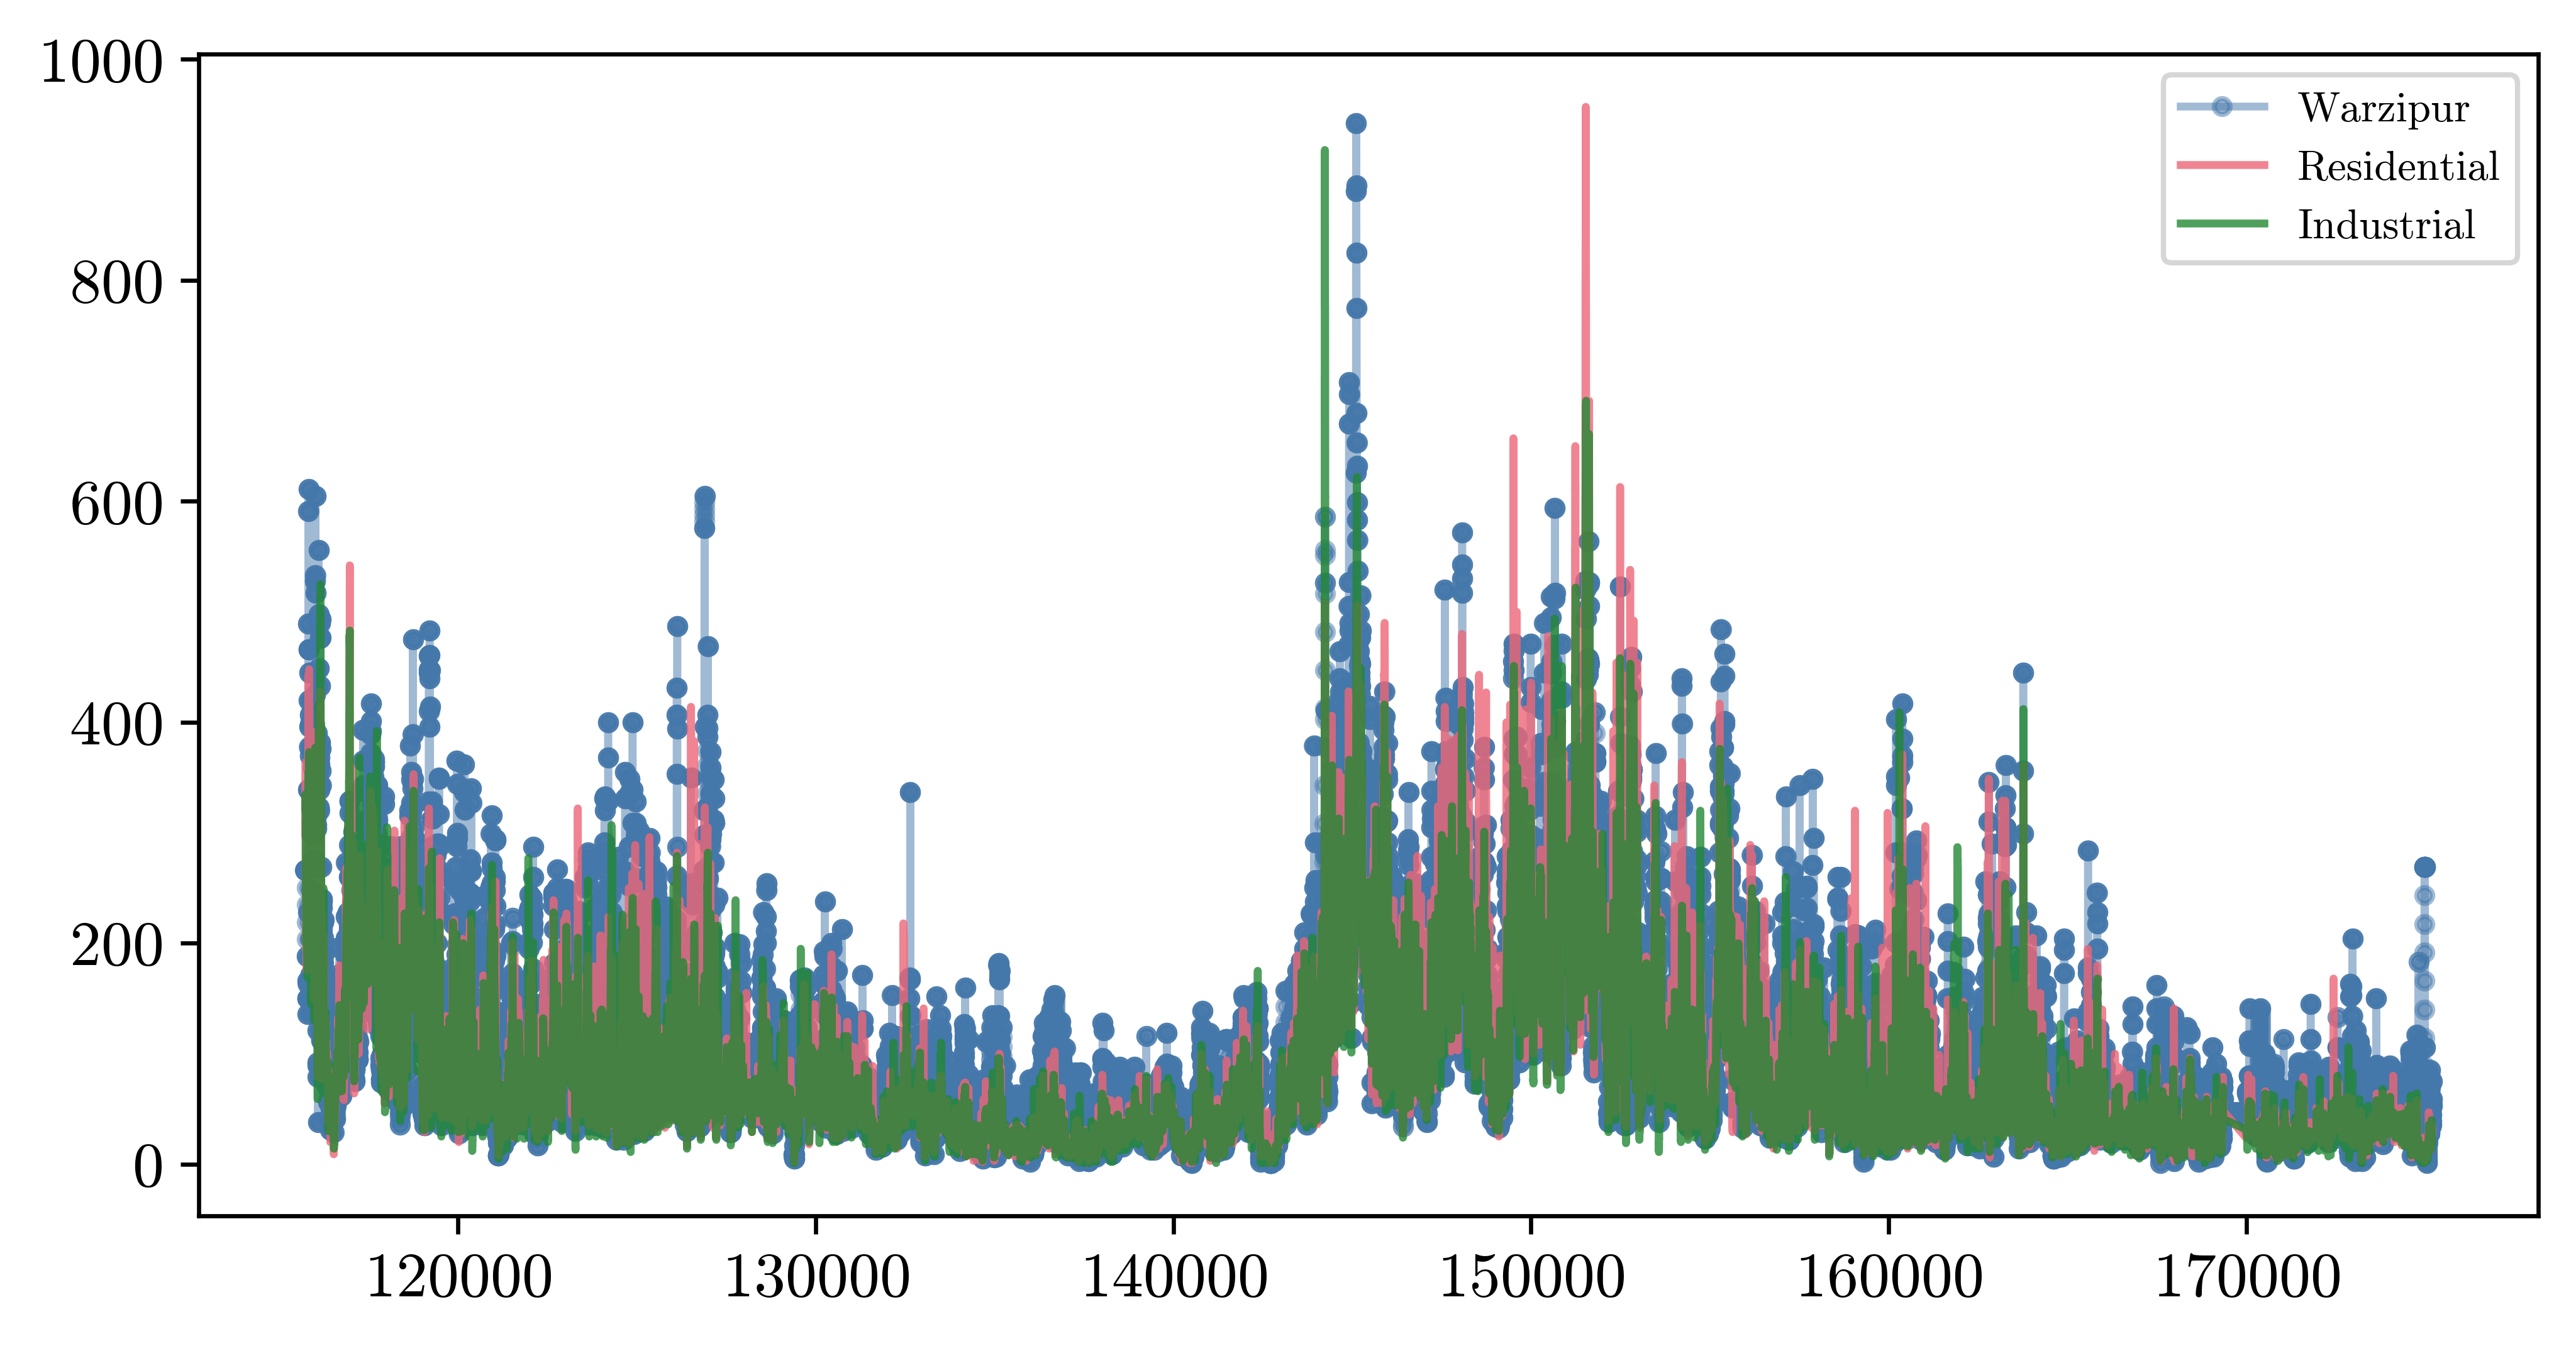

In [95]:
plt.plot(df1['PM2.5'],'-',marker='.',alpha=0.5)
plt.plot(df2['PM2.5'],alpha=0.8)
plt.plot(df3['PM2.5'],alpha=0.8)
plt.legend(['Warzipur','Residential','Industrial'])
plt.show()

### K-Means

1: Industrial
2: Commercial
3: Residential

In [ ]:
s1=df_delhi_clustered[df_delhi_clustered['Landuse_label']==1].SiteId.values
s2=df_delhi_clustered[df_delhi_clustered['Landuse_label']==2].SiteId.values
s3=df_delhi_clustered[df_delhi_clustered['Landuse_label']==3].SiteId.values

In [ ]:
df_stats[df_stats['SiteId'].isin(s1)].describe()

In [ ]:
df_stats[df_stats['SiteId'].isin(s2)].describe()

In [ ]:
df_stats[df_stats['SiteId'].isin(s3)].describe()